# Working on KDEs :

## Robustness of Mtomo-MDM (Many mocks) :

check all kdes :

In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter
import importlib
plt.style.use('paper.mystyle')

In [2]:
def get_kde(M1, M2, mmin= 13, mmax= 16):

    from scipy.stats import gaussian_kde as gkde
    
    data = np.zeros((2,M1.size))
    data[0,:] = M1
    data[1,:] = M2

    kernel = gkde(data)  
    X, Y = np.mgrid[mmin:mmax:50j, mmin:mmax:50j]
    grid_points = np.vstack([X.ravel(), Y.ravel()])
    Z = np.reshape(kernel(grid_points).T, X.shape)
    del X, Y
    
    return Z

def plot_Mtomo_MDM(fig, ax, Mtomo, MDM, signif=None, title='', xlabel=r'$\rm M_{tomo}$',  ylabel=r'$\mathrm{M_{DM, noiseless}}$',
                   data_for_Drew=None, co=None, legend=True, plot_kde=False, plot_points=True):
    
    import scipy.stats
    from scipy.stats import linregress
    
    mmin, mmax = 13, 16
    
    if plot_kde :
        
        Z = get_kde(Mtomo, MDM)
        im = ax.imshow(np.rot90(Z), cmap=plt.cm.viridis, extent = [mmin, mmax, mmin, mmax] )
        cb = fig.colorbar(im, ax=ax, orientation='horizontal', pad=0.10)
        cb.ax.set_xlabel('Gaussian KDE')
    
    
    if co is None:
        co = linregress(Mtomo-14, MDM)
        #print('fitting line :', co)

    else :
        x = np.array([13-14,16])
        ax.plot(x, co[0]*(x-14)+co[1], alpha=0.7, label='power-law estimator',ls='dotted')
    
    ax.plot([13,16],[13,16], alpha=0.7, color='k', label='1:1', ls='--')
    
    if plot_points :
        if signif is None :
            ax.scatter(Mtomo, MDM, alpha=0.3)
        else :
            ind1 = (signif > -2.5)*(signif < -2.35)
            ind2 = (signif > -3.0)*(signif < -2.5)
            ind3 = (signif > -3.5)*(signif < -3.0)
            ind4 = (signif < -3.5)
            ax.scatter( Mtomo[ind1], MDM[ind1], alpha=0.6, label=r'$-2.5 < \sigma < -2.35$', s=300, facecolor='None', edgecolor='C1', marker='^', lw=1)
            ax.scatter( Mtomo[ind2], MDM[ind2], alpha=0.6, label=r'$-3.0 < \sigma < -2.5$', s=300, facecolor='None', edgecolor='r', marker='D', lw=1)
            ax.scatter( Mtomo[ind3], MDM[ind3], alpha=0.6, label=r'$-3.5 < \sigma < -3.0$', s=300, facecolor='None', edgecolor='k', marker='o', lw=1)
            ax.scatter( Mtomo[ind4], MDM[ind4], alpha=0.6, label=r'$ \sigma < -3.5 $', s=300, facecolor='None', edgecolor='C8', marker='*', lw=1)
            if data_for_Drew is not None:
                fw = h5py.File(data_for_Drew, 'w')
                fw['Mtomo'] = Mtomo
                fw['MDM'] = MDM
                fw['signif'] = signif
            
    ax.set_xlim((13,16))
    ax.set_xticks(np.arange(13.5,16))
    ax.set_ylim((13,16))
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True, alpha=0.7)
    ax.set_title(title)
    if legend:
        ax.legend( framealpha=0.8, loc=(1.05, 0.2), fontsize=30, facecolor='C0')

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


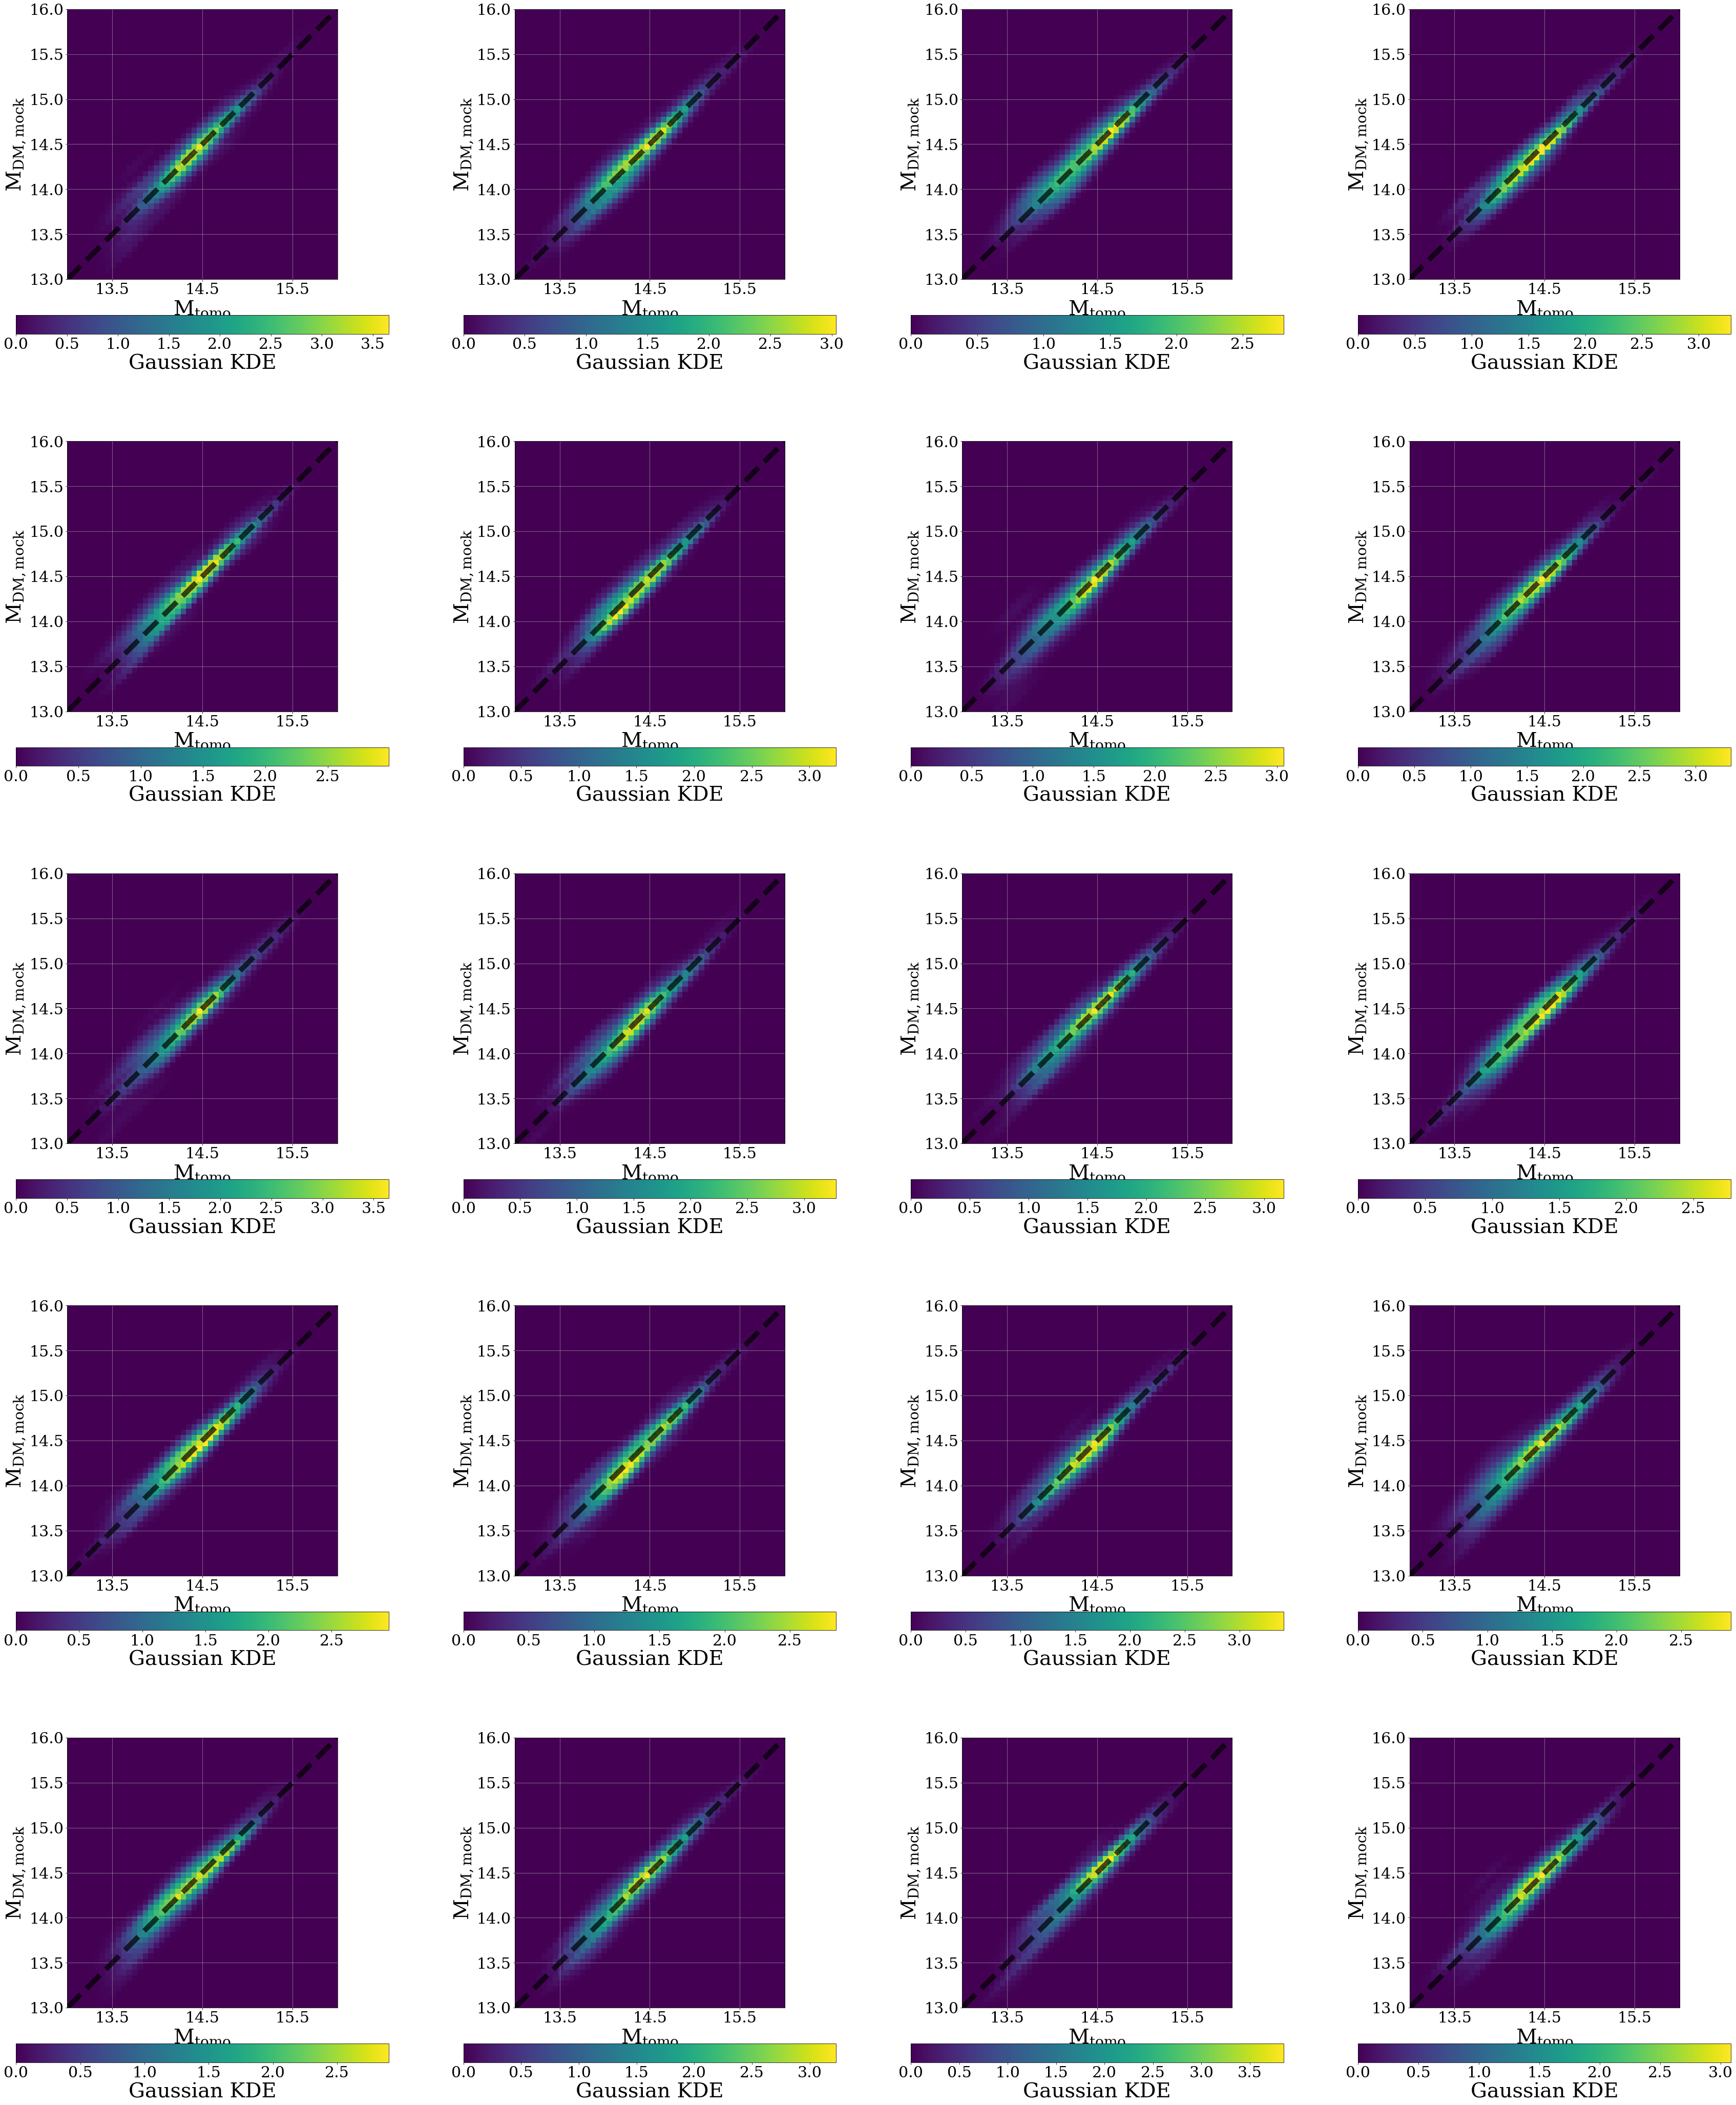

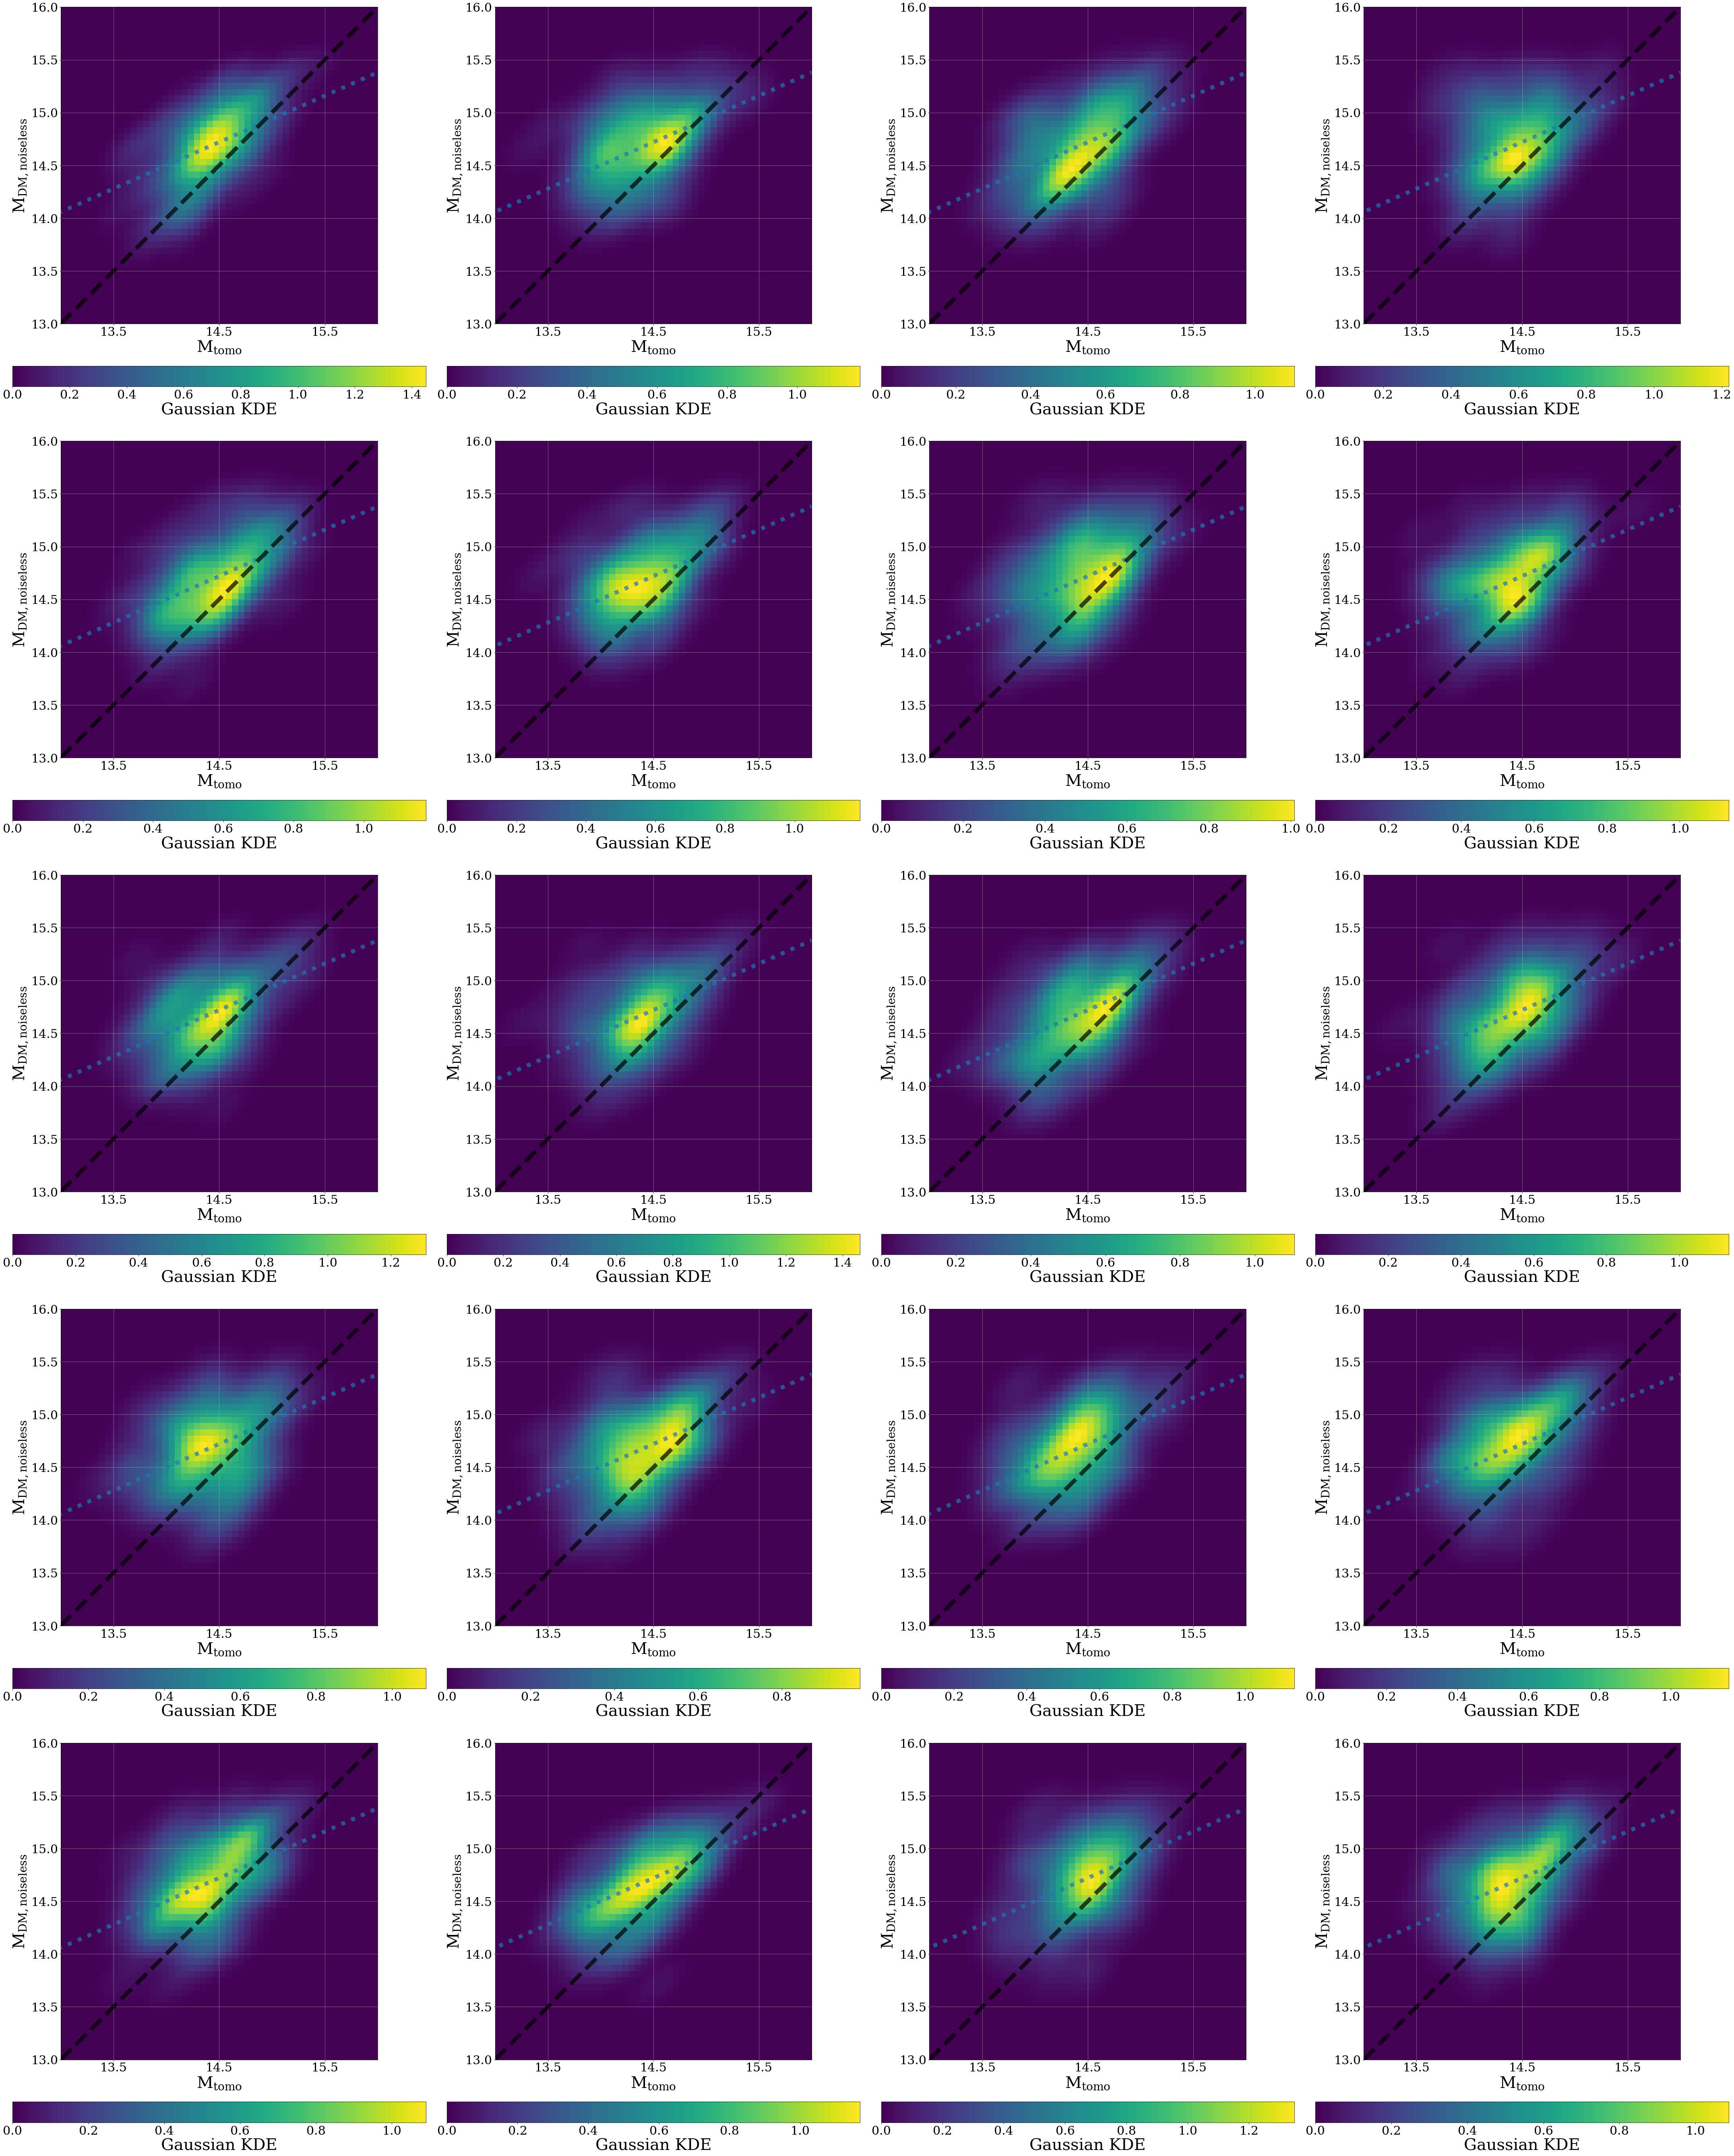

In [5]:
def plot_many():
    fig1, ax1 = plt.subplots(5,4, figsize=(60,75))
    fig2, ax2 = plt.subplots(5,4, figsize=(60,75))
    
    f = h5py.File('./DataPaper/Mtomo_MDM.hdf5','r')
    for n in range(1,21):
        plot_Mtomo_MDM(fig1, ax1[int((n-1)/4), (n-1)%4], f[str(n)+'/Mtomo_mock'][:], f[str(n)+'/MDM_mock'][:], signif=None,
                       xlabel=r'$\rm M_{tomo}$', ylabel=r'$\rm M_{DM, mock}$', legend=False, plot_kde=True, plot_points=False)
        plot_Mtomo_MDM(fig2, ax2[int((n-1)/4), (n-1)%4], f[str(n)+'/Mtomo_mock_overlap'][:], f[str(n)+'/MDM_true_overlap'][:],
                       signif=None, co=(0.44, 14.50), legend=False, plot_kde=True, plot_points=False)
        
    f.close()
    plt.tight_layout()
plot_many()

In [53]:
def plot_kde_mean_variance(co=[0.44,14.5], nmocks=20, mmin=13,mmax=16, first_plot=False):
    import matplotlib
    f = h5py.File('./DataPaper/Mtomo_MDM_z2.4_th2.35_lc2.00.hdf5','r')
    Zall = []
    if first_plot:
        for n in np.arange(1,nmocks+1):
            Zall.append(get_kde(f[str(n)+'/Mtomo_mock'][:], f[str(n)+'/MDM_mock'][:]))
    else:
        for n in np.arange(1,nmocks+1):
            Zall.append(get_kde(f[str(n)+'/Mtomo_mock_overlap'][:], f[str(n)+'/MDM_true_overlap'][:]))
    f.close()
    
    Zmean = np.zeros(shape=(50,50))
    Zvar = np.zeros(shape=(50,50))
    for Z in Zall:
        Zmean += Z
    Zmean /= nmocks
    for Z in Zall:
        Zvar  += (Z - Zmean)**2
    
    Zvar = np.sqrt(Zvar/nmocks)
        
    fig, ax = plt.subplots(1,2,figsize=(20,10))
    
    ax[0].set_xlabel(r'$\rm M_{tomo}$') 
    ax[1].set_xlabel(r'$\rm M_{tomo}$') 
    if first_plot:
        vmax= 3
        ax[0].set_ylabel(r'$\rm M_{DM, mock}$')
        ax[1].set_ylabel(r'$\rm M_{DM, mock}$')
    else:
        vmax= 1
        ax[0].set_ylabel(r'$\mathrm{M_{DM, noiseless}}$')
        ax[1].set_ylabel(r'$\mathrm{M_{DM, noiseless}}$')
    
    ax[0].set_title('Mean')
    im = ax[0].imshow(np.rot90(Zmean), cmap=plt.cm.viridis, norm=matplotlib.colors.LogNorm(vmin=.01, vmax=10),extent = [mmin, mmax, mmin, mmax])
    cb = fig.colorbar(im, ax=ax[0], orientation='horizontal', pad=0.15, shrink=0.5)
    cb.ax.set_xlabel('Gaussian KDE')
    
    ax[1].set_title('Variance')
    im = ax[1].imshow(np.rot90(Zvar), cmap=plt.cm.viridis, norm=matplotlib.colors.LogNorm(vmin=.01, vmax=10), extent = [mmin, mmax, mmin, mmax])
    cb = fig.colorbar(im, ax=ax[1], orientation='horizontal', pad=0.15, shrink=0.5)
    cb.ax.set_xlabel('Gaussian KDE')
    
    # Power law fit :
    x = np.array([13,16])
    if not first_plot:
        ax[0].plot(x, co[0]*(x-14)+co[1], alpha=0.7, label='power-law estimator',ls='dashed')
    ax[0].plot([13,16],[13,16], alpha=0.5, color='k', label='1:1', ls='dotted')
    ax[1].plot([13,16],[13,16], alpha=0.5, color='k', label='1:1', ls='dotted')
    
    # Max probability :
    ymax = np.argmax(Zmean, axis=1)
    xmax = mmin + ((mmax - mmin)/50)*np.arange(50)
    ymax = mmin + ((mmax - mmin)/50)*ymax

    ax[0].plot(xmax, ymax, alpha=0.5)
    ax[0].grid()
    ax[1].grid()
    plt.tight_layout()

In [54]:
plot_kde_mean_variance(first_plot=True)
plot_kde_mean_variance(first_plot=False)
plt.savefig('Mtomo_MDM.png')

ValueError: operands could not be broadcast together with shapes (50,50) (80,160) (50,50) 

## For Mtomo-vs-vsM(z=0)

Next cell in borrowed from `M0_Mtomo,ipynb`  :

In [32]:
def get_ind_non_overlapping(lmap1, lmap2):
    """Returns the indices in the lmap1 which overlap with no satershed in lmap2"""
    ind = np.where(lmap2!=0)
    id_overlapping = np.unique(lmap1[ind])[1:]
    id_non_overlapping = np.unique(lmap1)[1:][np.isin(np.unique(lmap1)[1:], id_overlapping, invert=True)]
    
    return id_overlapping.astype(int) - 1, id_non_overlapping.astype(int) - 1
    
    
def get_Mtomo_GroupMass_true(n=1, th=2.35, lc=2.0, offset=0.214, z=2.4):
    
    lc=str(lc).ljust(4,'0')
    th = str(th).ljust(4,'0')

    f = h5py.File('./halos/descendants/Mass_voted_FOF_halos_true_z'+str(z)+'_n1_sigma4_th'+th+'_halos_lc'+lc+'.hdf5','r')
    peaks = h5py.File('./thresh/n'+str(n)+'/peaks_TNG_true_z'+str(z)+'_n'+str(n)+'_sigma4_th'+th+'_lc'+lc+'.hdf5','r')
    GroupMass = 10+np.log10(f['GroupMass'][:])
    ind = f['peak_id'][:].astype(int)-1
    Mtomo = peaks['mtomo'][:][ind] + offset
    
    return Mtomo, GroupMass, 0

def get_Mtomo_GroupMass_true_sigma2(n, offset=0.214, z=2.4):
    f = h5py.File('./halos/descendants/Mass_voted_FOF_halos_true_z2.4_n'+str(n)+'_sigma2_th2.75_halos_lc2.30.hdf5','r')
    peaks = h5py.File('./thresh/n1/peaks_TNG_true_z2.4_n'+str(n)+'_sigma2_th2.75_lc2.30.hdf5','r')
    GroupMass = 10+np.log10(f['GroupMass'][:])
    ind = f['peak_id'][:].astype(int)-1
    Mtomo = peaks['mtomo'][:][ind] + offset
    
    return Mtomo, GroupMass, 0

def get_Mtomo_GroupMass(n, z=2.4, th=2.35, lc=2.0, offset=0.214):
    
    lc=str(lc).ljust(4,'0')
    th = str(th).ljust(4,'0')
    f = h5py.File('./halos/descendants/Mass_voted_FOF_halos_z'+str(z)+'_n'+str(n)+'_sigma4_th'+th+'_halos_lc'+lc+'.hdf5','r')
    peaks = h5py.File('./thresh/n'+str(n)+'/peaks_TNG_z'+str(z)+'_n'+str(n)+'_sigma4_th'+th+'_lc'+lc+'.hdf5','r')
    GroupMass = 10+np.log10(f['GroupMass'][:])
    ind = f['peak_id'][:].astype(int)-1
    Mtomo = peaks['mtomo'][:][ind] + offset
    signif = peaks['signif'][ind]
    
    return Mtomo, GroupMass, signif

def get_Mtomo_GroupMass_sigma2(n, z=2.4, offset=0.214):
    f = h5py.File('./halos/descendants/Mass_voted_FOF_halos_z2.4_n'+str(n)+'_sigma2_th2.75_halos_lc2.30.hdf5','r')
    peaks = h5py.File('./thresh/n'+str(n)+'/peaks_TNG_z2.4_n'+str(n)+'_sigma2_th2.75_lc2.30.hdf5','r')
    GroupMass = 10+np.log10(f['GroupMass'][:])
    ind = f['peak_id'][:].astype(int)-1
    Mtomo = peaks['mtomo'][:][ind] + offset
    signif = peaks['signif'][ind]
    
    return Mtomo, GroupMass, signif

def get_Mtomo_GroupMass_random(n, offset=0.214, z=2.4):
    if z==2.4:
        lc=str(2.00).ljust(4,'0')
        th = str(2.35).ljust(4,'0')
    if z==2.3:
        lc=str(2.35).ljust(4,'0')
        th=str(2.75).ljust(4,'0')
    if z==2.6:
        lc=str(1.90).ljust(4,'0')
        th=str(2.40).ljust(4,'0')
        
    f = h5py.File('./halos/descendants/Mass_voted_FOF_halos_z'+str(z)+'_n'+str(n)+'_sigma4_th'+th+'_halos_lc'+lc+'_rnd.hdf5','r')
    peaks = h5py.File('./thresh/n'+str(n)+'/peaks_TNG_z'+str(z)+'_n'+str(n)+'_sigma4_th'+th+'_lc'+lc+'_rnd.hdf5','r')
    GroupMass = 10+np.log10(f['GroupMass'][:])
    ind = f['peak_id'][:].astype(int)-1
    Mtomo = peaks['mtomo'][:][ind] + offset
    signif = peaks['signif'][ind]
    
    return Mtomo, GroupMass, signif


def get_the_mean_fit(z=2.4, offset=0.214,  nrange=np.arange(1,17,1), random=False, sigma2=False):
    
    from scipy.stats import linregress
    slopes, intercepts, M1test, M2test = [], [], [], []
    if random:
        get_masses = get_Mtomo_GroupMass_random
    elif sigma2 :
        get_masses = get_Mtomo_GroupMass_sigma2
    
    else:
        get_masses = get_Mtomo_GroupMass
    
    
    for n in nrange:
        M1, M2, _ = get_masses(n=n, z=z, offset=offset)
        co = linregress(M1 - 14, M2) 
        slopes.append(co[0])
        intercepts.append(co[1])
        
    slope_mean, intercept_mean = np.mean(slopes), np.mean(intercepts)
    
    print('Slope : ', str(slope_mean)[:5]+'+-'+str(np.std(slopes))[:5])
    print('The prefactor : ', str(intercept_mean)[:5]+'+-'+str(np.std(intercepts))[:5])
    #print('The prefactor in our fit : '+str(intercept_mean+14*slope_mean)[:5]+' +- '+ 
    #                                        str(np.sqrt((14*np.std(slopes))**2 + np.std(intercepts)**2))[:5])
    return (slope_mean, intercept_mean)

def _get_err(co, M1, M2, bins=np.array([13, 13.75, 14.25, 14.75, 15.5])):
    
    fit = lambda x : co[0]*(x-14) +co[1]
    err = []
    for i in range(bins.size-1):
        ind = np.where( (M1 > bins[i])*(M1 < bins[i+1]))
        dev = fit(M1[ind]) - M2[ind]
        err.append(np.sqrt(np.sum(dev*dev)/dev.size))
    return np.array(err)


def test_fit(co, z=2.4, offset=0.214, ntest=np.arange(17,21), bins= np.array([13, 14, 14.25, 14.75, 15.5]), random=False, sigma2=False):
    """Find the errors for in mass bins of bins for the mock maps array of ntest"""
    
    if random:
        get_masses = get_Mtomo_GroupMass_random
    elif not sigma2:
        get_masses = get_Mtomo_GroupMass
    else:
        get_masses = get_Mtomo_GroupMass_sigma2

    errall = np.zeros(shape=(ntest.size, bins.size-1))
    for i, n in enumerate(ntest):
        M1, M2, _ = get_masses(n, z=z, offset=offset)
        errall[i,:] = _get_err(co, M1, M2, bins)
   
    return bins, errall

def get_kde(M1, M2, minmax=(13,16,10,16)):

    from scipy.stats import gaussian_kde as gkde
    
    data = np.zeros((2,M1.size))
    data[0,:] = M1
    data[1,:] = M2

    kernel = gkde(data)  
    X, Y = np.mgrid[minmax[0]:minmax[1]:80j, minmax[2]:minmax[3]:160j]
    grid_points = np.vstack([X.ravel(), Y.ravel()])
    Z = np.reshape(kernel(grid_points).T, X.shape)
    del X, Y
    
    return Z


def get_mean_KDE(Mtomo_func, offset=0.214,  z=2.4, nmocks=20):
    
    Zall = []
    for n in np.arange(1,nmocks+1):
        Mtomo, GroupMass, _ = Mtomo_func(n=n, z=z, offset=offset)
        Zall.append(get_kde(Mtomo, GroupMass))

    Zmean = np.zeros(shape=(80,160))
    for Z in Zall:
        Zmean += Z
    Zmean /= nmocks
    for Z in Zall:
        Zstd =+ (Z-Zmean)**2
    Zstd /= nmocks
    Zstd = np.sqrt(Zstd)
    
    return Zmean, Zstd
        

In [13]:
def get_Mtomo_GroupMass(n=1, offset=0.214):
    f = h5py.File('./halos/descendants/RootDescen_all_halos_wshed_minrad2_sigma2_z2.4_n'+str(n)+'_th3.00_lc2.45.hdf5','r')
    peaks = h5py.File('./thresh/n'+str(n)+'/peaks_TNG_z2.4_n'+str(n)+'_sigma2_th3.00_lc2.45.hdf5','r')
    GroupMass = 10+np.log10(f['GroupMass'][:])
    ind = f['PeakIDs'][:].astype(int)-1
    Mtomo = peaks['mtomo'][:][ind] + offset
    
    return Mtomo, GroupMass, 0

def plot_many():
    fig1, ax1 = plt.subplots(5,4, figsize=(60,75))
    fig2, ax2 = plt.subplots(5,4, figsize=(60,75))
    
    
    for n in range(1,21):
        Mtomo, GroupMass, _ = get_Mtomo_GroupMass_true(n=n)
        plot_Mtomo_MDM(fig1, ax1[int((n-1)/4), (n-1)%4], Mtomo, GroupMass, signif=None,
                       xlabel=r'$\rm M_{tomo}$', ylabel=r'$\rm M_{DM, mock}$', legend=False, plot_kde=True, plot_points=False)
        plot_Mtomo_MDM(fig2, ax2[int((n-1)/4), (n-1)%4], Mtomo, GroupMass,
                       signif=None, co=(0.44, 14.50), legend=False, plot_kde=True, plot_points=False)
        
    f.close()
    plt.tight_layout()

In [ ]:
plot_many()

In [55]:
def plot_kde_mean_variance(co=[0.44,14.5], z=2.4, nmocks=20, mmin=13,mmax=16, sigma=4, offset=0.241):
    import matplotlib
    Mtomo_func = get_Mtomo_GroupMass
    Zmean, Zstd = get_mean_KDE(Mtomo_func, z=z, offset=offset)
    fig, ax = plt.subplots(1,2,figsize=(20,10))
    
    ax[0].set_xlabel(r'$\rm M_{tomo}$') 
    ax[1].set_xlabel(r'$\rm M_{tomo}$') 
    ax[0].set_ylabel(r'$\mathrm{M_{desc}}$')
    ax[1].set_ylabel(r'$\mathrm{M_{desc}}$')
    
    ax[0].set_title('Mean')
    im = ax[0].imshow(np.rot90(Zmean), cmap=plt.cm.viridis, norm=matplotlib.colors.LogNorm(vmin=.01, vmax=1), extent = [mmin, mmax, mmin, mmax])
    cb = fig.colorbar(im, ax=ax[0], orientation='horizontal', pad=0.15, shrink=0.5)
    cb.ax.set_xlabel('Gaussian KDE')
    
    ax[1].set_title('Variance')
    im = ax[1].imshow(np.rot90(Zstd), cmap=plt.cm.viridis, norm=matplotlib.colors.LogNorm(vmin=.01, vmax=1), extent = [mmin, mmax, mmin, mmax])
    cb = fig.colorbar(im, ax=ax[1], orientation='horizontal', pad=0.15, shrink=0.5)
    cb.ax.set_xlabel('Gaussian KDE')
    
    # Power law fit :
    x = np.array([13,16])
    #ax[0].plot(x, co[0]*(x-14)+co[1], alpha=0.7, label='power-law estimator',ls='dashed')
    ax[0].plot([13,16],[13,16], alpha=0.5, color='k', label='1:1', ls='dotted')
    ax[1].plot([13,16],[13,16], alpha=0.5, color='k', label='1:1', ls='dotted')
    
    # Max probability :
    ymax = np.argmax(Zmean, axis=1)
    xmax = mmin + ((mmax - mmin)/80)*np.arange(80)
    ymax = mmin + ((mmax - mmin)/160)*ymax

    ax[0].plot(xmax, ymax, alpha=0.5)
    ax[0].grid()
    ax[1].grid()
    plt.tight_layout()

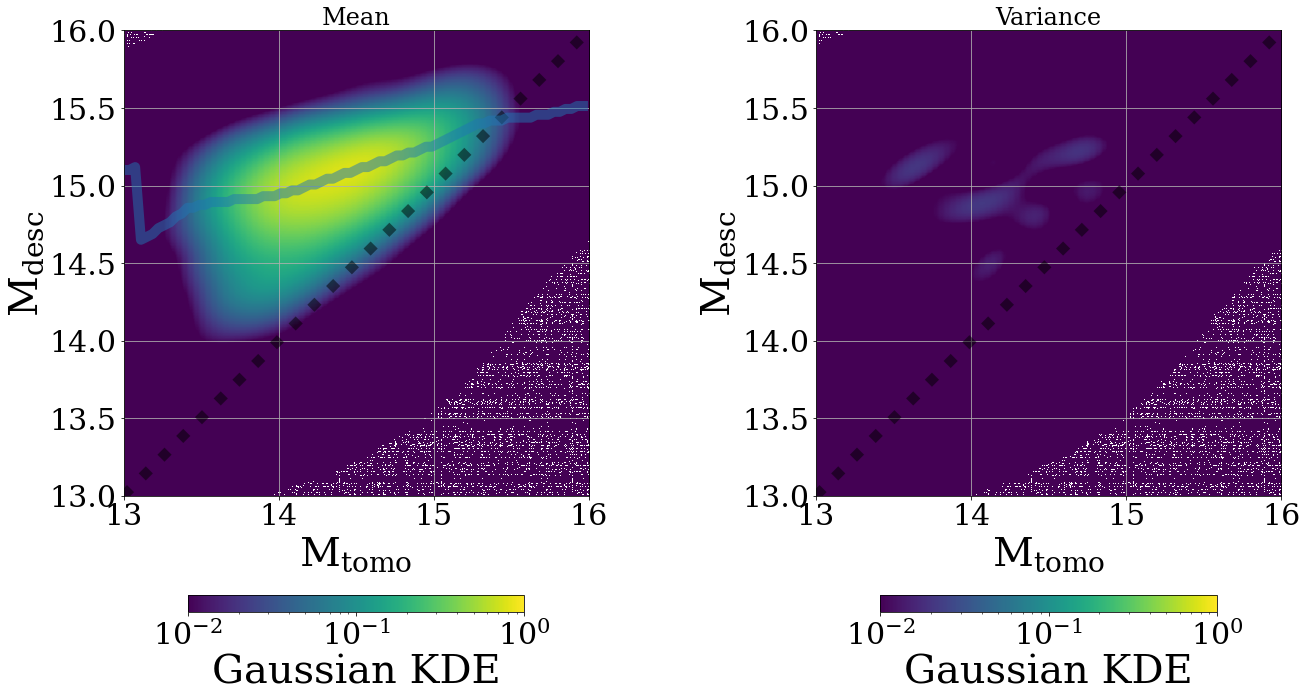

In [56]:
plot_kde_mean_variance(z=2.4, sigma=4)

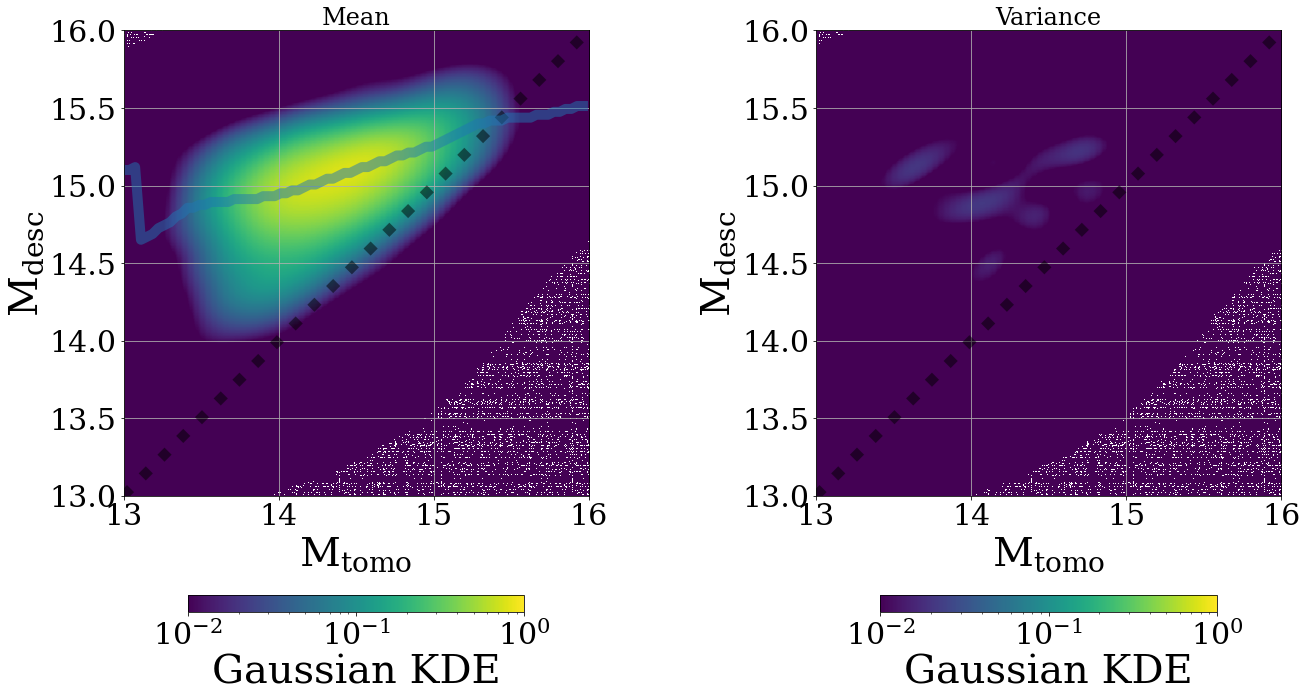

In [57]:
plot_kde_mean_variance(sigma=2)